<a href="https://colab.research.google.com/github/bikash-bhoi/END_NLP_P1/blob/main/Session5_LSTM/END_S5_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')

In [ ]:
data = open('text.txt', 'r').read()

In [ ]:
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("Corona Virus article has %d characters, %d unique characters" %(data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

Corona Virus article has 10223 characters, 75 unique characters


In [ ]:
hidden_layer_size = 100
time_steps = 40
learning_rate = 1e-1
weight_sd = 0.1
z_size = hidden_layer_size + X_size

In [ ]:
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

def dsigmoid(x):
    return x * (1 - x)

def tanh(x):
    x = np.asarray(x)
    return (np.exp(2*x) - 1) / (np.exp(2 * x) + 1)

def dtanh(x):
    return 1 - x * x

In [ ]:
# Question 1 :
sigmoid(0)

0.5

In [ ]:
# Question 2 
dsigmoid(sigmoid(0))

0.25

In [ ]:
# Question 3
tanh(dsigmoid(sigmoid(0)))

0.24491866240370913

In [ ]:
# Question 4
dtanh(tanh(dsigmoid(sigmoid(0))))

0.940014848806378

In [ ]:
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value
        self.d = np.zeros_like(value)
        self.m = np.zeros_like(value)

# Question 4
size_a = hidden_layer_size# write your code here
size_b = z_size# write your code here
size_c = X_size# write your code here

class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', np.random.randn(size_a, size_b) * weight_sd + 0.5)
        self.b_f = Param('b_f', np.zeros((size_a, 1)))

        self.W_i = Param('W_i', np.random.randn(size_a, size_b) * weight_sd + 0.5)
        self.b_i = Param('b_i', np.zeros((size_a, 1)))

        self.W_C = Param('W_C', np.random.randn(size_a, size_b) * weight_sd)
        self.b_C = Param('b_C', np.zeros((size_a, 1)))

        self.W_o = Param('W_o', np.random.randn(size_a, size_b) * weight_sd + 0.5)
        self.b_o = Param('b_o', np.zeros((size_a, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v', np.random.randn(X_size, size_a) * weight_sd)
        self.b_v = Param('b_v', np.zeros((size_c, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

In [ ]:
{x.name: x.v for x in parameters.all()}.keys()


dict_keys(['W_f', 'W_i', 'W_C', 'W_o', 'W_v', 'b_f', 'b_i', 'b_C', 'b_o', 'b_v'])

In [ ]:
def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (hidden_layer_size, 1)
    assert C_prev.shape == (hidden_layer_size, 1)
    param_dict = {x.name: x.v for x in parameters.all()}
    W_f = param_dict['W_f']
    W_i = param_dict['W_i']
    W_C = param_dict['W_C']
    b_f = param_dict['b_f']
    b_i = param_dict['b_i']
    b_C = param_dict['b_C']
    W_o = param_dict['W_o']
    b_o = param_dict['b_o']
    W_v = param_dict['W_v']
    b_v  = param_dict['b_v']
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(W_f, z) + b_f)# write your code here
    i = sigmoid(np.dot(W_i, z) + b_i) # write your code here
    C_bar =tanh(np.dot(W_C, z) + b_C)# write your code here

    C = f * C_prev + i * C_bar# write your code here
    o =  sigmoid(np.dot(W_o, z) + b_o )# write your code here
    h = o * tanh(C)# write your code here

    v = np.dot(W_v, h) + b_v# write your code here
    y = np.exp(v) / (np.sum(np.exp(v)) + 1e-8) #softmax

    return z, f, i, C_bar, C, o, h, v, y

In [ ]:
# Question 5
len(forward(np.zeros((X_size, 1)), np.zeros((hidden_layer_size, 1)), np.zeros((hidden_layer_size, 1)), parameters))

9

In [ ]:
# question 6
z, f, i, C_bar, C, o, h, v, y = forward(np.zeros((X_size, 1)), np.zeros((hidden_layer_size, 1)), np.zeros((hidden_layer_size, 1)))

In [ ]:
z.shape, np.sum(z), np.sum(f)

((175, 1), 0.0, 50.0)

In [ ]:
def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + hidden_layer_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (hidden_layer_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:hidden_layer_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

In [ ]:
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

In [ ]:
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == time_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

In [ ]:
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

In [ ]:
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

In [ ]:
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

In [ ]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * time_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

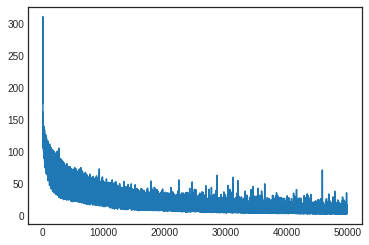

----
 puliny and in haminger your cold in Wuhan that symptoms have been diagnose , fulifor and monter and in huper in 16 cough. He started in Chinavious out if ble bat conting with linger of the dise weres  
----
iter 49900, loss 7.722342


In [ ]:
iter = 50000
while iter > 0:
  # Reset
  if pointer + time_steps >= len(data) or iteration == 0:
      g_h_prev = np.zeros((hidden_layer_size, 1))
      g_C_prev = np.zeros((hidden_layer_size, 1))
      pointer = 0


  inputs = ([char_to_idx[ch] 
              for ch in data[pointer: pointer + time_steps]])
  targets = ([char_to_idx[ch] 
              for ch in data[pointer + 1: pointer + time_steps + 1]])

  loss, g_h_prev, g_C_prev = \
      forward_backward(inputs, targets, g_h_prev, g_C_prev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001

  # Print every hundred steps
  if iteration % 100 == 0:
      update_status(inputs, g_h_prev, g_C_prev)

  update_paramters()

  plot_iter = np.append(plot_iter, [iteration])
  plot_loss = np.append(plot_loss, [loss])

  pointer += time_steps
  iteration += 1
  iter = iter -1

## iter 49900, loss 7.722342
